In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import threading
import obspy
from obspy.clients.seedlink.easyseedlink import create_client, EasySeedLinkClient

## realtime station information
http://ds.iris.edu/gmap/#network=_REALTIME&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

http://ds.iris.edu/gmap/#network=_REALTIME&channel=HH*&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

In [189]:
import obspy
import os
import pickle
import datetime
import numpy as np

pi = 3.1415926
degree2km = pi*6371/180

## Location
# center = (-115.53, 32.98) #salton sea
# center = (-117.504, 35.705) #ridgecrest
center = (-155.32, 19.39) #havaii
horizontal_degree = 2.0
vertical_degree = 2.0

## Time range
#     starttime = obspy.UTCDateTime("2020-10-01T00") #salton sea
#     endtime = obspy.UTCDateTime("2020-10-03T00") ## not included
starttime = obspy.UTCDateTime("2021-04-05T00") #ridgecrest
endtime = obspy.UTCDateTime("2021-04-06T00") ## not included

## seismic stations
network_list = ["HV", "PT"]
# channel_list = "HHE,HHN,HHZ,BHE,BHN,BHZ,EHE,EHN,EHZ"
channel_list = "HH*,BH*,EH*"
# channel_list = "HHE,HHN,HHZ"

## data center
client = "IRIS"

####### save config ########
config = {}
config["center"] = center
config["xlim_degree"] = [center[0]-horizontal_degree/2, center[0]+horizontal_degree/2]
config["ylim_degree"] = [center[1]-vertical_degree/2, center[1]+vertical_degree/2]
config["degree2km"] = degree2km
config["starttime"] = starttime.datetime
config["endtime"] = endtime.datetime
config["networks"] = network_list
config["channels"] = channel_list
config["client"] = client

63


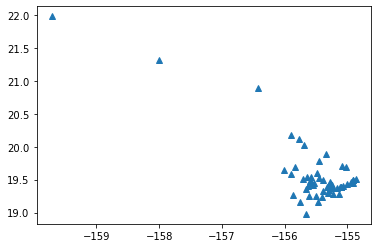

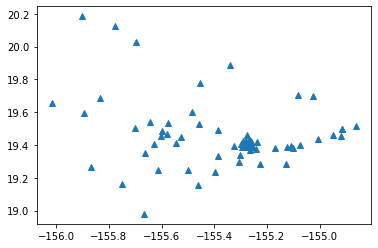

In [190]:
stations_total = pd.read_csv("realtime-stations.txt", sep="|",  header=None, skiprows=3, names=["network", "station", "latitude", "longitude", "elevation(m)", "location", "starttime", "endtime"])
stations_total = stations_total[stations_total["network"].isin(NETWORK)]

plt.figure()
plt.plot(stations_total["longitude"], stations_total["latitude"], '^')
# plt.axis("scaled")

stations_select = stations_total[(config["xlim_degree"][0] < stations_total["longitude"]) & (stations_total["longitude"] < config["xlim_degree"][1])\
& (config["ylim_degree"][0] < stations_total["latitude"]) & (stations_total["latitude"] < config["ylim_degree"][1])]

stations_select = stations_select.reset_index()
print(len(stations_select))
plt.figure()
plt.plot(stations_select["longitude"], stations_select["latitude"], '^')
# plt.axis("scaled")

Number of stations: 62


Text(0.5, 1.0, 'Number of stations: 67')

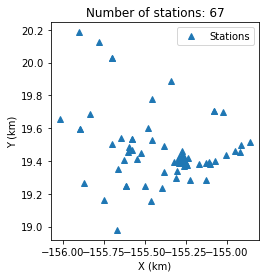

In [192]:
import pickle, os
import obspy
from obspy.clients.fdsn import Client
from collections import defaultdict
import pandas as pd
#     import matplotlib
#     matplotlib.use("agg")
#     import matplotlib.pyplot as plt

####### Download stations ########
stations = Client("IRIS").get_stations(network = ",".join(config["networks"]),
                                       station = ",".join(stations_select["station"]),
                                       starttime=config["starttime"],
                                       endtime=config["endtime"],
                                       minlongitude=config["xlim_degree"][0],
                                       maxlongitude=config["xlim_degree"][1],
                                       minlatitude=config["ylim_degree"][0],
                                       maxlatitude=config["ylim_degree"][1],
                                       channel=config["channels"],
                                       level="response")#,
#                                            filename="stations.xml")

#     stations = obspy.read_inventory("stations.xml")
print("Number of stations: {}".format(sum([len(x) for x in stations])))
# stations.plot('local', outfile="stations.png")
# stations.plot('local')

####### Save stations ########
station_locs = defaultdict(dict)
station_resp = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            station_resp[f"{network.code}.{station.code}.{chn.location_code}.{chn.code}"] =\
                chn.response.instrument_sensitivity.value
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = chn.longitude, chn.latitude, chn.elevation
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs.to_csv("stations.csv",
                    sep="\t", float_format="%.3f",
                    index_label="station",
                    columns=["longitude", "latitude", "elevation(m)", "unit", "component", "response"])


#     ####### Plot stations ########
plt.figure()
plt.plot(station_locs["longitude"], station_locs["latitude"], "^", label="Stations")
#     plt.plot(catalog["x(km)"], catalog["y(km)"], "k.", label="Earthquakes")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("scaled")
plt.legend()
plt.title(f"Number of stations: {len(station_locs)}")
#     plt.savefig(os.path.join(data_path, "stations_loc.png"))
# plt.show()

In [187]:
class Client(EasySeedLinkClient):
    def on_data(self, trace):
        print('Received trace:', trace.id)
        print(trace)
        value = {"timestamp":trace.stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3], "vec":trace.data.tolist()}
            
client = Client('rtserve.iris.washington.edu:18000')
for x in station_locs.index:
    x = x.split(".")
    client.select_stream(x[0], x[1], x[-1]+"?")
client.run()

Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:12.875000Z - 2021-04-05T22:26:16.165000Z | 100.0 Hz, 330 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:16.175000Z - 2021-04-05T22:26:19.435000Z | 100.0 Hz, 327 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:19.445000Z - 2021-04-05T22:26:22.775000Z | 100.0 Hz, 334 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:22.785000Z - 2021-04-05T22:26:26.125000Z | 100.0 Hz, 335 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:26.135000Z - 2021-04-05T22:26:29.925000Z | 100.0 Hz, 380 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:29.935000Z - 2021-04-05T22:26:33.375000Z | 100.0 Hz, 345 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:33.385000Z - 2021-04-05T22:26:36.525000Z | 100.0 Hz, 315 samples
Received trace: HV.ERZ4..HHE
HV.ERZ4..HHE | 2021-04-05T22:26:36.535000Z - 2021-04-05T22:26:39.815000Z | 100.0 Hz, 329 

KeyboardInterrupt: 